In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow_datasets as tfds
import os
import matplotlib.pyplot as plt
import json
from PIL import Image, ImageDraw
import numpy as np

In [ ]:
# download if u havnt

# !curl -O https://storage.googleapis.com/quickdraw_dataset/full/simplified/face.ndjson
# !curl -O https://storage.googleapis.com/quickdraw_dataset/full/simplified/cloud.ndjson
# !curl -O https://storage.googleapis.com/quickdraw_dataset/full/simplified/door.ndjson

In [ ]:
def draw_strokes(strokes, size=224):
    img = Image.new("RGB", (256, 256), "white")  # RGB mode, 3 channels
    draw = ImageDraw.Draw(img)

    for stroke in strokes:
        points = list(zip(stroke[0], stroke[1]))
        draw.line(points, fill="black", width=5)

    img = img.resize((size, size))

    img_rgb = np.array(img) / 255.0  # normalize

    return img_rgb

def load_quickdraw_classes(files, label_map, limit_per_class=1000, size=224):
    images = []
    labels = []

    for label_name, class_index in label_map.items():
        with open(files[label_name], 'r') as f:
            for i, line in enumerate(f):
                if i >= limit_per_class:
                    break
                item = json.loads(line)
                img = draw_strokes(item['drawing'], size)
                images.append(img)
                labels.append(class_index)

    # Convert to tensors
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)

    labels = tf.one_hot(labels, depth=len(label_map))

    return tf.data.Dataset.from_tensor_slices((images, labels))

In [ ]:
files = {
    "face": "face.ndjson",
    "door": "door.ndjson",
    "cloud": "cloud.ndjson"
}

label_map = {"face": 0, "door": 1, "cloud": 2}

dataset = load_quickdraw_classes(files, label_map, limit_per_class=500)


Image batch shape: (224, 224, 3)
Label batch shape: (3,)


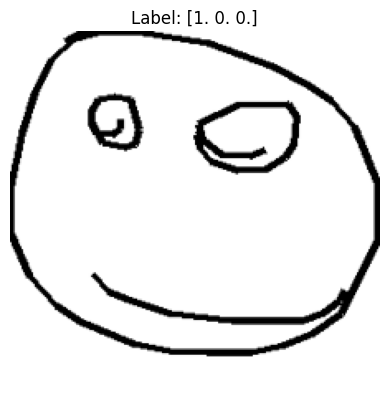

In [ ]:
for images, labels in dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

    img = images.numpy()
    label = labels.numpy()

    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

In [ ]:
# set the size percentage of train, test, and validation
train_size = 0.8
test_size = 0.1
val_size = 0.1

# get the actual len of each sub datasets
dataset_size = len(dataset)
train_size = int(dataset_size * train_size)
test_size = int(dataset_size * test_size)
val_size = int(dataset_size * val_size)

dataset = dataset.shuffle(3000, reshuffle_each_iteration=False)

# allot the each sub datasets their data
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(test_size)
test_dataset = dataset.skip(train_size + test_size).take(val_size)

# batch and prefetch the sub datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 3)


In [ ]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [ ]:
vgg16_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
myModel = models.Sequential()
for layer in vgg16_model.layers[:-1]:
    myModel.add(layer)

In [ ]:
for layer in myModel.layers:
    layer.trainable = False

myModel.add(Dense(units=3, activation='softmax'))

In [ ]:
myModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │        12,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,272,835 (512.21 MB)

 Trainable params: 12,291 (48.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [ ]:
myModel.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = myModel.fit(x=train_dataset, epochs=15, validation_data=val_dataset)

Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 658ms/step - accuracy: 0.4999 - loss: 1.1565 - val_accuracy: 0.7133 - val_loss: 0.8314
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step - accuracy: 0.8705 - loss: 0.7411 - val_accuracy: 0.9600 - val_loss: 0.6060
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 192ms/step - accuracy: 0.9571 - loss: 0.5466 - val_accuracy: 0.9667 - val_loss: 0.4658
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.9629 - loss: 0.4224 - val_accuracy: 0.9600 - val_loss: 0.3762
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.9678 - loss: 0.3418 - val_accuracy: 0.9600 - val_loss: 0.3163
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 0.9733 - loss: 0.2871 - val_accuracy: 0.9600 - val_loss: 0.2743
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.9733 - loss: 0.2480 - val_accuracy: 0.9667 - val_loss: 0.2434
Epoch 8/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - accuracy: 0.9743 - loss: 0.2189 - val_accura

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

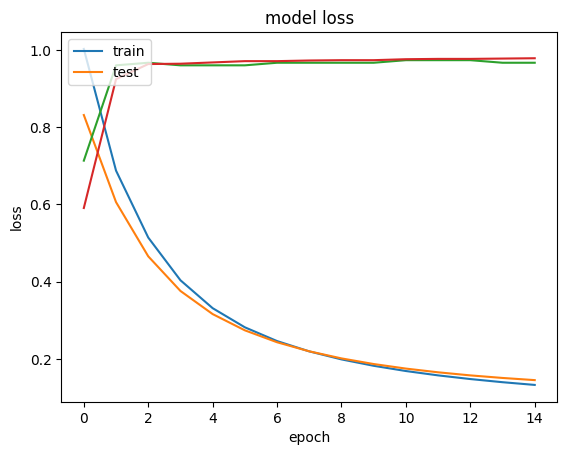

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.plot(history.history['val_accuracy'], label='test acc')
plt.plot(history.history['accuracy'], label='train acc')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
results = myModel.evaluate(test_dataset)
results

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.9817 - loss: 0.0953


[0.09581781178712845, 0.9866666793823242]

In [ ]:
import os.path

In [ ]:
if os.path.isfile('myModel.keras') is False:
    myModel.save('myModel.keras')